Importing all the necessary libraries.

In [2]:
!pip install wandb
import os
import math
import numpy as np
import time
from torch.utils.data import DataLoader
import os
from torchvision import transforms
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.utils.data as data
from PIL import Image
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm


**PART 1.A**

In [7]:
!cp /content/drive/MyDrive/Cropped_final-20240218T071405Z-001.zip .
!pwd
!ls
!unzip /content/drive/MyDrive/Cropped_final-20240218T071405Z-001.zip
!ls

Streaming output truncated to the last 5000 lines.
  inflating: Cropped_final/roe_deer/0056_rd_n_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0822_sd_n_s_crop02_detections.jpg  
  inflating: Cropped_final/sika_deer/0808_sd_n_s_crop00_detections.jpg  
  inflating: Cropped_final/roe_deer/0044_rd_d_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0808_sd_n_w_crop00_detections.jpg  
  inflating: Cropped_final/roe_deer/0045_rd_d_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0810_sd_d_w_crop01_detections.jpg  
  inflating: Cropped_final/roe_deer/0035_rd_d_crop00_detections.jpg  
  inflating: Cropped_final/roe_deer/0037_rd_d_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0846_sd_d_s_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0812_sd_n_s_crop00_detections.jpg  
  inflating: Cropped_final/sika_deer/0817_sd_n_s_crop01_detections.jpg  
  inflating: Cropped_final/roe_deer/0033_rd_d_crop00_detections.jpg  
  inflating: Cropp

NameError: name 'y' is not defined

In [12]:
!ls
!pwd

Cropped_final  Cropped_final-20240218T071405Z-001.zip  drive  sample_data
/content


In [13]:
# here we create a list named mydata, which contains the path address to the images.

# this is the label wala dictinory
Labels = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear':4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

# here we import all the requisite libraries

# defined the root_path to the folder where the data is contained
root_path = '/content/Cropped_final'

# created an empty list of mydata
myData = []

# Iterating through sub-folders
for class_name, class_label in Labels.items():
    class_folder = os.path.join(root_path, class_name) #opening the class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpg') or f.endswith('.png')] # accesing the image files in the directory
    myData.extend([(os.path.join(class_folder, image_file), class_label) for image_file in image_files]) # appending the data in mydata

# mydata = torch.Tensor(mydata)

In [14]:
train_data, test_data = train_test_split(myData, test_size=0.3, stratify=[item[1] for item in myData], shuffle = True)
val_data, test_data = train_test_split(test_data, test_size=0.2, stratify=[item[1] for item in test_data], shuffle = True)

In [15]:
class Wildlife(data.Dataset):
    def __init__(self, data, transform=None):
        super().__init__()
        self.data = data
        self.transform = transform


    def __len__(self):
        # returns the size of the dataset
        return len(self.data)


    def __getitem__(self, idx):
    #    return the item at idx
        image_path, image_class = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, image_class  #for right now this is returning none, but have to return the image at idx

transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()])

mydata_train = Wildlife(train_data, transform)
mydata_val = Wildlife(val_data, transform)
mydata_test = Wildlife(test_data, transform)

**PART 1.B**

In [16]:
train_loader = DataLoader(mydata_train, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(mydata_val, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(mydata_test, batch_size=64, shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Part 1.C**

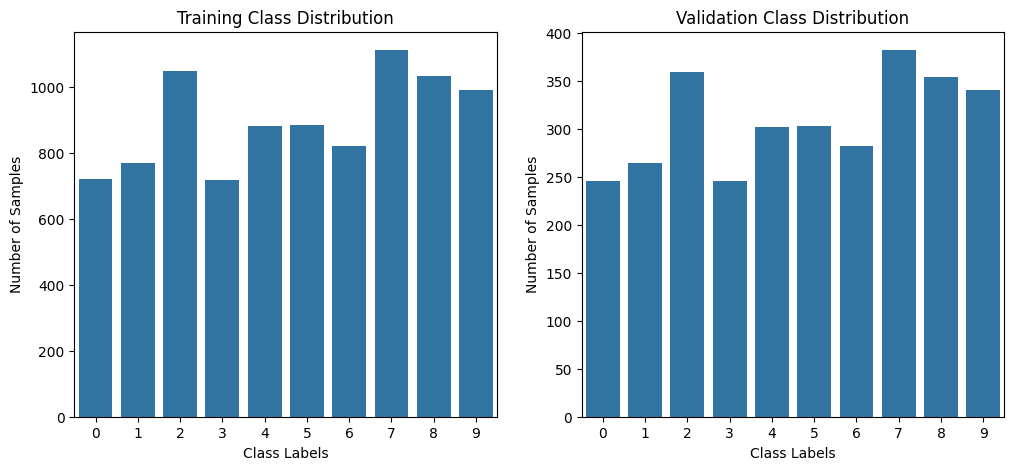

In [17]:
import seaborn as sns
num_classes = 10

train_labels = [item[1] for item in train_data]
val_labels = [item[1] for item in val_data]

class_labels = [f'Class {i}' for i in range(num_classes)]
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=train_labels)
plt.title('Training Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

plt.subplot(1, 2, 2)
sns.countplot(x=val_labels)
plt.title('Validation Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Number of Samples')

plt.show()



**PART 2.A**

In [18]:
class CNNArchitecture(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear((128 * 14 * 14), 256)
        self.fc2 = nn.Linear(256, 10)  # Assuming 10 output classes for classification

    def forward(self, x):
        # Convolutional layers
        y=x.shape[0]

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)


        # Flatten the output
        x = x.view(y, -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model = CNNArchitecture()
print(model)


CNNArchitecture(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [19]:
from prettytable import PrettyTable
def model_parameters_table(model):
    table = PrettyTable(["Layer", "Parameter Count"])

    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            table.add_row([name, num_params])

    table.add_row(["Total", total_params])
    return table
print(model_parameters_table(model))

+--------------+-----------------+
|    Layer     | Parameter Count |
+--------------+-----------------+
| conv1.weight |       864       |
|  conv1.bias  |        32       |
| conv2.weight |      18432      |
|  conv2.bias  |        64       |
| conv3.weight |      73728      |
|  conv3.bias  |       128       |
|  fc1.weight  |     6422528     |
|   fc1.bias   |       256       |
|  fc2.weight  |       2560      |
|   fc2.bias   |        10       |
|    Total     |     6518602     |
+--------------+-----------------+


**PART 2.B**

In [ ]:
wandb.login()
run = wandb.init(project='Wildlife', entity='Pratham_03')
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# wandb.log(commit='Running for dummy variable\n')
model = CNNArchitecture()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, epochs + 1):
    model.train()


    running_loss = 0.0
    correct_train = 0
    total_train = 0
    #  running for dummy
    for i, data in enumerate(train_loader,0):
        # print(i)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(len(inputs))
        # print(len(labels))
        # print(outputs[0])

        optimizer.zero_grad()
        # print(inputs[0][4][0][0])

        outputs = model(inputs)
        # print(len(outputs))


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    model.eval()

    running_val_loss = 0.0
    correct_val = 0
    total_val = 0


    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / len(val_loader)

    wandb.log({"Epoch": epoch, "Train Loss": train_loss, "Train Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy})

    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy}")

torch.save(model.state_dict(), "model1.pth")
wandb.finish()


In [ ]:
torch.save(model, "model_cnn.pt")

**PART 2.D**

In [25]:
from sklearn.metrics import f1_score

running_test_loss = 0.0
correct_test = 0
total_test = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


model = CNNArchitecture()
model.load_state_dict(torch.load("/content/drive/MyDrive/model1.pth", map_location = torch.device('cpu')))
model.to(device)



with torch.no_grad():
  for inputs, gnd_truth in test_loader:
    inputs, gnd_truth = inputs.to(device), gnd_truth.to(device)
    output = model(inputs)
    test_loss = criterion(output, gnd_truth)

    running_test_loss += test_loss.item()

    _, predicted = torch.max(output.data, 1)
    total_test += gnd_truth.size(0)
    correct_test += (predicted == gnd_truth).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)
f1 = f1_score(gnd_truth, predicted, average = 'weighted')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
print(f" Loss: {test_loss:.4f}, Accuracy: {test_accuracy}")
print(f"F1SCORE: {f1:.4f}")

 Loss: 1.3181, Accuracy: 0.5831168831168831
F1SCORE: 0.0000


In [ ]:
import wandb

# ... your code for calculating the confusion matrix (e.g., using scikit-learn)

# Log the confusion matrix
wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
    probs=None,  # Set to None if not using probabilities
    y_true=ground_truth,
    preds=predictions,
    class_names=class_names)})

<ipython-input-16-c0428b5e4b27>:5: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


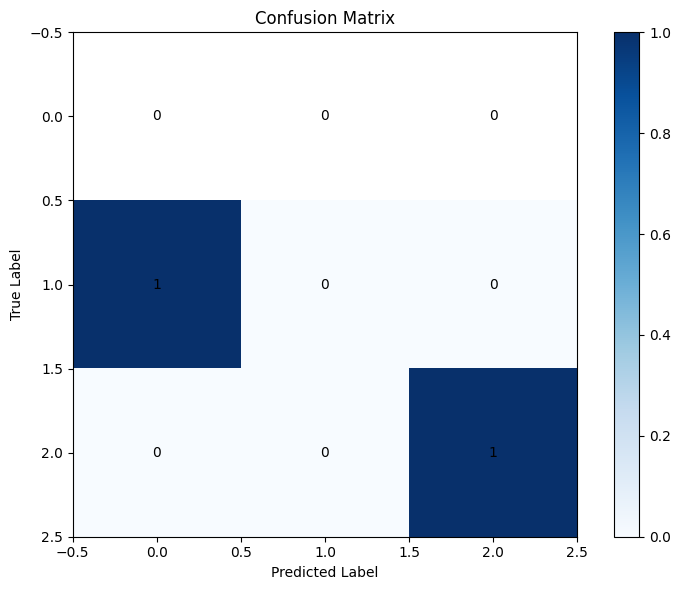

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gnd_truth.cpu(), predicted.cpu())

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.colorbar()

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Add individual cell values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()

**PART 3.A**

In [27]:
preprocess = transforms.Compose([
    transforms.Resize((224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Labels = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear':4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

root_path = '/content/Cropped_final'

# created an empty list of mydata
myData = []

# Iterating through sub-folders
for class_name, class_label in Labels.items():
    class_folder = os.path.join(root_path, class_name) #opening the class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpg') or f.endswith('.png')] # accesing the image files in the directory
    myData.extend([(os.path.join(class_folder, image_file), class_label) for image_file in image_files]) # appending the data in mydata


train_data, test_data = train_test_split(myData, test_size=0.3, stratify=[item[1] for item in myData], shuffle=True)
val_data, test_data = train_test_split(test_data, test_size=0.2, stratify=[item[1] for item in test_data], shuffle=True)

mydata_train = Wildlife(train_data, preprocess)
mydata_val = Wildlife(val_data, preprocess)
mydata_test = Wildlife(test_data, preprocess)

train_loader = DataLoader(mydata_train, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(mydata_val, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(mydata_test, batch_size=64, shuffle=False, num_workers=8)

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
wandb.login()
run = wandb.init(project='Wildlife', entity='Pratham_03')
torch.manual_seed(42)
from tqdm import tqdm

import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(512, 10)

model.to(device)

# mydata = torch.Tensor(mydata)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(1, epochs + 1)):
    model.train()


    running_loss = 0.0
    correct_train = 0
    total_train = 0
    #  running for dummy
    for i, data in enumerate(tqdm(train_loader),0):
        # print(i)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(len(inputs))
        # print(len(labels))
        # print(outputs[0])

        optimizer.zero_grad()
        # print(inputs[0][4][0][0])

        outputs = model(inputs)
        # print(len(outputs))


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    model.eval()

    running_val_loss = 0.0
    correct_val = 0
    total_val = 0


    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / len(val_loader)

    wandb.log({"Epoch": epoch, "Train Loss": train_loss, "Train Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy})

    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy}")

torch.save(model.state_dict(), "model2.pth")
torch.save(model, "model2.pt")
wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pratham21082. Use `wandb login --relogin` to force relogin


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 142MB/s]
  0%|          | 0/141 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/util

Epoch 1/10 - Train Loss: 8.6262, Train Accuracy: 0.5924 - Validation Loss: 4.0381, Validation Accuracy: 0.6192332683560754



 20%|██        | 2/10 [03:37<14:28, 108.55s/it]

Epoch 2/10 - Train Loss: 3.1307, Train Accuracy: 0.7000 - Validation Loss: 3.2540, Validation Accuracy: 0.6985055230669266



 30%|███       | 3/10 [05:26<12:43, 109.07s/it]

Epoch 3/10 - Train Loss: 3.3934, Train Accuracy: 0.7029 - Validation Loss: 4.5825, Validation Accuracy: 0.6630929174788824



 40%|████      | 4/10 [07:23<11:13, 112.26s/it]

Epoch 4/10 - Train Loss: 3.4719, Train Accuracy: 0.7198 - Validation Loss: 4.7421, Validation Accuracy: 0.6575698505523067



 50%|█████     | 5/10 [09:23<09:35, 115.07s/it]

Epoch 5/10 - Train Loss: 3.0305, Train Accuracy: 0.7426 - Validation Loss: 4.3416, Validation Accuracy: 0.7089018843404808



 60%|██████    | 6/10 [11:14<07:34, 113.51s/it]

Epoch 6/10 - Train Loss: 3.6354, Train Accuracy: 0.7319 - Validation Loss: 4.8158, Validation Accuracy: 0.6949317738791423



 70%|███████   | 7/10 [13:08<05:40, 113.53s/it]

Epoch 7/10 - Train Loss: 3.8582, Train Accuracy: 0.7338 - Validation Loss: 3.7538, Validation Accuracy: 0.7478882391163093



 80%|████████  | 8/10 [14:56<03:43, 111.80s/it]

Epoch 8/10 - Train Loss: 3.1106, Train Accuracy: 0.7603 - Validation Loss: 3.8158, Validation Accuracy: 0.7348927875243665



 90%|█████████ | 9/10 [16:45<01:50, 110.93s/it]

Epoch 9/10 - Train Loss: 3.4109, Train Accuracy: 0.7484 - Validation Loss: 4.6176, Validation Accuracy: 0.714100064977258



100%|██████████| 10/10 [18:34<00:00, 111.40s/it]

Epoch 10/10 - Train Loss: 3.4607, Train Accuracy: 0.7566 - Validation Loss: 5.0804, Validation Accuracy: 0.7222222222222222


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▆▆▇▇▇███
Train Loss,█▁▁▂▁▂▂▁▁▂
Validation Accuracy,▁▅▃▃▆▅█▇▆▇
Validation Loss,▄▁▆▇▅▇▃▃▆█
Epoch,10
Train Accuracy,0.7566
Train Loss,3.46066
Validation Accuracy,0.72222
Validation Loss,5.08039


In [ ]:
!cp /content/model2.pth .

cp: '/content/model2.pth' and './model2.pth' are the same file


In [ ]:
!ls

Cropped_final				drive	   model2.pth	wandb
Cropped_final-20240218T071405Z-001.zip	model2.pt  sample_data


**PART 3.C**

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Loss: 5.0859, Accuracy: 0.7168831168831169
F1 SCORE: 0.0000


<ipython-input-18-c6dcc3bc34de>:42: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


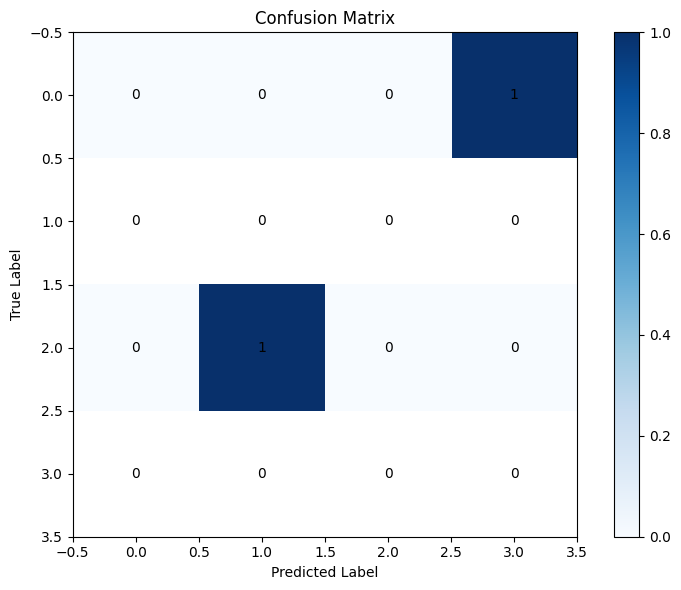

In [18]:
from sklearn.metrics import f1_score

running_test_loss = 0.0
correct_test = 0
total_test = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.fc = torch.nn.Linear(512, 10)
model.load_state_dict(torch.load("model2.pth", map_location = torch.device('cpu')))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


with torch.no_grad():
  for inputs, gnd_truth in test_loader:
    inputs, gnd_truth = inputs.to(device), gnd_truth.to(device)
    output = model(inputs)
    test_loss = criterion(output, gnd_truth)

    running_test_loss += test_loss.item()

    _, predicted = torch.max(output.data, 1)
    total_test += gnd_truth.size(0)
    correct_test += (predicted == gnd_truth).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)
f1 = f1_score(gnd_truth.cpu(), predicted.cpu(), average = 'weighted')

print(f" Loss: {test_loss:.4f}, Accuracy: {test_accuracy}")
print(f"F1 SCORE: {f1:.4f}")

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gnd_truth.cpu(), predicted.cpu())

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.colorbar()

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Add individual cell values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
model = model.to("cpu")

PART 3.D

  0%|          | 0/141 [00:00<?, ?it/s]

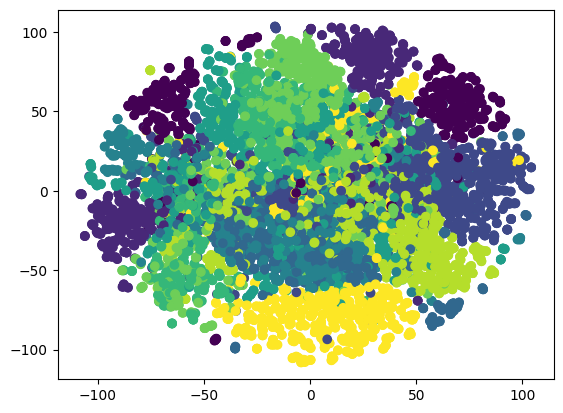

In [21]:
backbone_model = nn.Sequential(*list(model.children())[:-1]).to(device)
backbone_model.eval()
feature_vectors, target_labels = torch.empty((0,512)), torch.empty((0))
with torch.no_grad():
  for i, data in enumerate(tqdm(train_loader),0):
          # print(i)
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = backbone_model(inputs).squeeze()
          feature_vectors = torch.vstack((feature_vectors, outputs.to("cpu")))
          target_labels = torch.cat((target_labels, labels.to("cpu")))

feature_vectors = feature_vectors.cpu().numpy()
target_labels = target_labels.cpu().numpy()

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(feature_vectors)

fig, ax = plt.subplots()
ax.scatter(X_embedded[:,0], X_embedded[:,1], c=target_labels)


  0%|          | 0/49 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


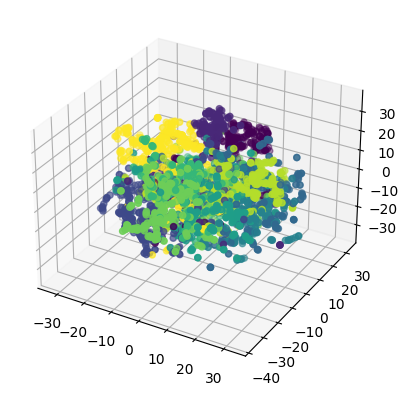

In [22]:
feature_vectors, target_labels = torch.empty((0,512), device=device), torch.empty((0), device=device)
with torch.no_grad():
  for i, data in enumerate(tqdm(val_loader),0):
          # print(i)
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = backbone_model(inputs).squeeze()
          feature_vectors = torch.vstack((feature_vectors, outputs))
          target_labels = torch.cat((target_labels, labels))

feature_vectors = feature_vectors.cpu().numpy()
target_labels = target_labels.cpu().numpy()

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(feature_vectors)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=target_labels)

**PART 4.A**

In [30]:
data_augmentation = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomInvert(0.3),
    transforms.RandomPerspective(distortion_scale = 0.6, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [31]:
root_path = '/content/Cropped_final'

# created an empty list of mydata
myData = []

# Iterating through sub-folders
for class_name, class_label in Labels.items():
    class_folder = os.path.join(root_path, class_name) #opening the class folder
    image_files = [f for f in os.listdir(class_folder) if f.endswith('.jpg') or f.endswith('.png')] # accesing the image files in the directory
    myData.extend([(os.path.join(class_folder, image_file), class_label) for image_file in image_files]) # appending the data in mydata


train_data, test_data = train_test_split(myData, test_size=0.3, stratify=[item[1] for item in myData], shuffle=True)
val_data, test_data = train_test_split(test_data, test_size=0.2, stratify=[item[1] for item in test_data], shuffle=True)

mydata_train = Wildlife(train_data, data_augmentation)
mydata_val = Wildlife(val_data, data_augmentation)
mydata_test = Wildlife(test_data, data_augmentation)

train_loader = DataLoader(mydata_train, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(mydata_val, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(mydata_test, batch_size=64, shuffle=False, num_workers=8)

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**PART 4.B**

In [ ]:
wandb.login()
run = wandb.init(project='Wildlife', entity='Pratham_03')
torch.manual_seed(42)
from tqdm import tqdm

import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(512, 10)

model.to(device)

# mydata = torch.Tensor(mydata)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(1, epochs + 1)):
    model.train()


    running_loss = 0.0
    correct_train = 0
    total_train = 0
    #  running for dummy
    for i, data in enumerate(tqdm(train_loader),0):
        # print(i)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # print(len(inputs))
        # print(len(labels))
        # print(outputs[0])

        optimizer.zero_grad()
        # print(inputs[0][4][0][0])

        outputs = model(inputs)
        # print(len(outputs))


        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    model.eval()

    running_val_loss = 0.0
    correct_val = 0
    total_val = 0


    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)

            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / len(val_loader)

    wandb.log({"Epoch": epoch, "Train Loss": train_loss, "Train Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy})

    print(f"Epoch {epoch}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy}")

torch.save(model.state_dict(), "model3.pth")
torch.save(model, "model3.pt")
wandb.finish()

In [ ]:
torch.save(model.state_dict(), "model3.pth")
torch.save(model, "model3.pt")

**PART 4.D**

In [ ]:
from sklearn.metrics import f1_score

running_test_loss = 0.0
correct_test = 0
total_test = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.load_state_dict(torch.load("model3.pth", map_location = torch.device('cpu')))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


with torch.no_grad():
  for inputs, gnd_truth in test_loader:
    inputs, gnd_truth = inputs.to(device), gnd_truth.to(device)
    output = model(inputs)
    test_loss = criterion(output, gnd_truth)

    running_test_loss += test_loss.item()

    _, predicted = torch.max(output.data, 1)
    total_test += gnd_truth.size(0)
    correct_test += (predicted == gnd_truth).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_test_loss / len(test_loader)
f1 = f1_score(gnd_truth.cpu(), predicted.cpu(), average = 'weighted')

print(f" Loss: {test_loss:.4f}, Accuracy: {test_accuracy}")
print(f"F1 SCORE: {f1:.4f}")

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(gnd_truth.cpu(), predicted.cpu())

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap plot
plt.figure(figsize=(8, 6))
plt.imshow(cm_norm, cmap=plt.cm.Blues)
plt.colorbar()

# Add labels and title
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Add individual cell values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.tight_layout()
plt.show()